# Cycling Activities for Outdoor Enthusiasts (EDA)

### Purpose
The purpose of this notebook is to explore the data that will be used to send a personalized newsletter inviting to a cycling activity.

### Structure
- Data exploration
- Location grouping
- Generating user features
- Various clustering techniques

### Utils

First, let's import key libraries and define a set of functions that will be used in the notebook.

In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import math
import itertools
from geopy.distance import geodesic
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


In [38]:
# Define colors for later use
folium_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
cluster_colors = {k: v for k, v in zip(range(1, len(folium_colors)+1), folium_colors)}
print(cluster_colors)

{1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange', 6: 'darkred', 7: 'lightred', 8: 'beige', 9: 'darkblue', 10: 'darkgreen', 11: 'cadetblue', 12: 'darkpurple', 13: 'white', 14: 'pink', 15: 'lightblue', 16: 'lightgreen', 17: 'gray', 18: 'black', 19: 'lightgray'}


In [3]:
# Function to calculate the distance between two points #1 (using the Haversine formula)
def calculate_distance_haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c

    return distance


In [4]:
# Function to calculate the distance between two points #1 (using the geodesic function from the geopy library)
def calculate_distance_geodesic(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

### Data

In [5]:
df = pd.read_csv('tours.csv.gz', compression='gzip')

In [6]:
df.shape

(19654, 3)

In [7]:
df.head()

,user_id,latitude,longitude
0,0280088d,52.552575,13.443113
1,0280088d,52.552958,13.442784
2,a6468bc1,52.457977,12.843970
3,0280088d,52.552796,13.441866
4,49b2ce0a,52.486855,13.551305


In [8]:
df['user_id'].nunique()

9632

We have data about 9632 unique users, having performed in total 19654 cycling activities.

### Locations

In [9]:
# Check for outliers
# Berlin: (52.520008, 13.404954)

df[['latitude', 'longitude']].describe()

,latitude,longitude
count,19654.000000,19654.000000
mean,52.493997,13.369972
std,0.097182,0.200209
min,52.186911,12.581296
25%,52.432550,13.270148
50%,52.499338,13.393642
75%,52.546528,13.476121
max,52.818415,14.017925


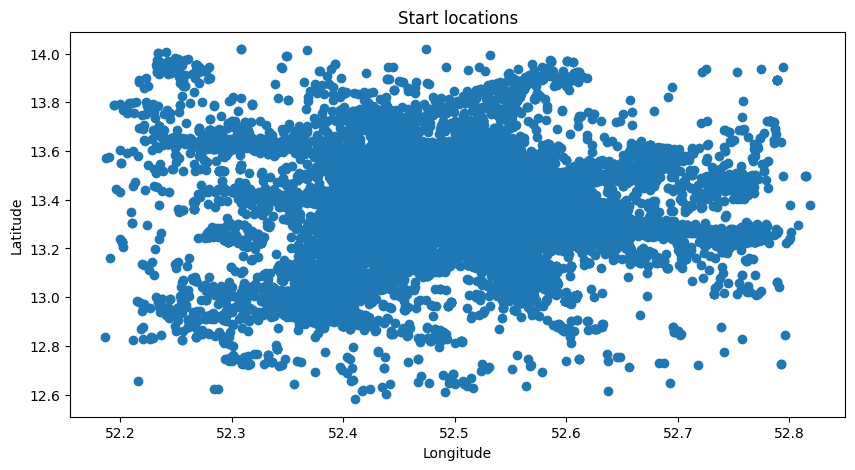

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

scatter1 = ax.scatter(x=df.latitude.values, y=df.longitude.values)

ax.set_title("Start locations")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

Coordinates available in the data set are centered around Berlin, with the highest density in locations close to the city center(s).

In [11]:
# Show (sampled) locations on a map of Berlin

n = 1000
m = folium.Map(location=[52.52, 13.41], zoom_start=10)

for index, row in df.sample(n).iterrows():
    lat = row['latitude']
    lon = row['longitude']
    folium.Marker([lat, lon]).add_to(m)
m

### Users

Now, let's explore the user a bit more.

In [13]:
# Create a df with unique users
df_users = df.groupby('user_id').size().sort_values(ascending=False).rename('ride_count')
df_users.sample(3)

user_id
ff5d66fe    1
fce0a7f7    1
1ab6b423    9
Name: ride_count, dtype: int64

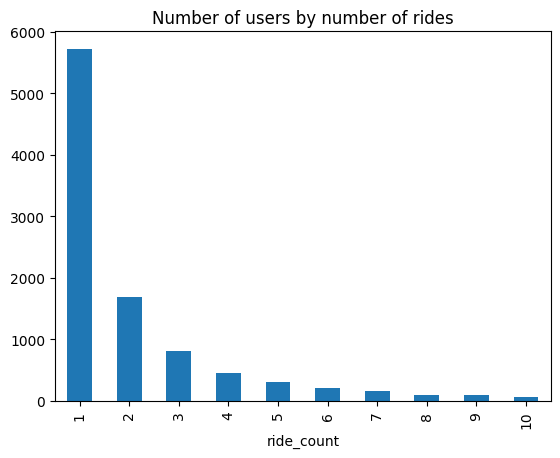

In [14]:
# Plot the number of users by number of rides
df_users.value_counts().sort_index().plot(kind='bar', title='Number of users by number of rides');

Majority of the user base performed just 1 cycling activity in the considered period of time. However, there are also users that went on multiple cycling trips (with max equal to 10).

In [15]:
# Concatenate coordinates all all rides, add it to the df_users
df['coordinates'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)

df0 = df.groupby('user_id')['coordinates'].apply(list)

df_users = pd.merge(df_users, df0, left_index=True, right_index=True)
df_users.sample(3)

,ride_count,coordinates
user_id,,
b94cd41a,5,"[(52.331823395826085, 13.607633877590237), (52..."
a3dba991,1,"[(52.50968060670353, 13.405084990313874)]"
c92e95c8,2,"[(52.740227803397424, 13.250884890443338), (52..."


#### Aggregate user's starting points

In this section I will check how starting points of a single user could be aggregated. 
Locations which are in close proximity to each other will be aggregated into a single point.  
It is important because the same user might start the ride from the same location multiple times, but the exact coordinates might differ slightly.
Also, one of the app's privacy feature, Privacy Zones, might be the reason for the same user's starting points to be slightly different. 
With that feature on, going from the same point but even in a different direction will result in a different starting point.


Aggregation of the starting points will result in a cleaner dataset, and then - might allow for a better user clustering.

##### Method 1 - Rounding (aka Naïve)

In [12]:
# Extra columns
df['latitude_approx'] = df['latitude'].apply(lambda x: round(x, 2))
df['longitude_approx'] = df['longitude'].apply(lambda x: round(x, 2))

In [16]:
# Start coordinates of might will slightly vary even if the location is basically the same
# Check if grouping by the approx coordinates is enough
df1 = df.groupby(['user_id', 'latitude_approx', 'longitude_approx']).size().rename('ride_count').sort_values(ascending=False)
df1.sample(2)

user_id   latitude_approx  longitude_approx
c867b3f2  52.34            13.40               1
d823df64  52.55            13.21               1
Name: ride_count, dtype: int64

In [17]:
# How many users have more than one start point?
df2 = df1.groupby('user_id').size().sort_values(ascending=False)
print(df2.head(3))
df2.value_counts()


user_id
0000571b    9
5e1bad97    9
d823df64    9
Name: ride_count, dtype: int64


ride_count
1    6902
2    1658
3     608
4     257
5     111
6      56
7      25
8      10
9       5
Name: count, dtype: int64

In [18]:
# User with more than 1 start point - 0000571b
df[df['user_id']=='0000571b'].sort_values(['latitude', 'longitude'])

,user_id,latitude,longitude,latitude_approx,longitude_approx,coordinates
15022,0000571b,52.403277,13.050781,52.40,13.05,"(52.40327687661756, 13.050780792228544)"
17220,0000571b,52.404652,13.047613,52.40,13.05,"(52.40465229882926, 13.047612945553045)"
11650,0000571b,52.405967,13.688889,52.41,13.69,"(52.40596723942356, 13.688888869476244)"
17218,0000571b,52.418764,13.808191,52.42,13.81,"(52.41876409544656, 13.808190985406446)"
17217,0000571b,52.437748,13.807098,52.44,13.81,"(52.43774846898206, 13.807097666976343)"
17219,0000571b,52.453703,13.582331,52.45,13.58,"(52.453702537519064, 13.582331178691645)"
9194,0000571b,52.464814,13.858726,52.46,13.86,"(52.46481360235066, 13.858726141500345)"
5085,0000571b,52.467889,13.562555,52.47,13.56,"(52.46788880950156, 13.562554777653745)"
9125,0000571b,52.588875,13.865565,52.59,13.87,"(52.58887462332606, 13.865564745221246)"
14949,0000571b,52.654897,13.270816,52.65,13.27,"(52.65489692877606, 13.270815662179546)"


In [55]:
user_id = '0000571b'
dfu = df[df['user_id']==user_id]
coord = dfu.groupby(['latitude_approx', 'longitude_approx']).size().rename('loc_size').sort_values(ascending=False).reset_index()
coord['loc_id'] = range(1, len(coord)+1)
dfu = pd.merge(dfu, coord, on=['latitude_approx', 'longitude_approx'])
dfu

,user_id,latitude,longitude,latitude_approx,longitude_approx,coordinates,loc_size,loc_id
0,0000571b,52.467889,13.562555,52.47,13.56,"(52.46788880950156, 13.562554777653745)",1,7
1,0000571b,52.588875,13.865565,52.59,13.87,"(52.58887462332606, 13.865564745221246)",1,8
2,0000571b,52.464814,13.858726,52.46,13.86,"(52.46481360235066, 13.858726141500345)",1,6
3,0000571b,52.405967,13.688889,52.41,13.69,"(52.40596723942356, 13.688888869476244)",1,2
4,0000571b,52.654897,13.270816,52.65,13.27,"(52.65489692877606, 13.270815662179546)",1,9
5,0000571b,52.403277,13.050781,52.40,13.05,"(52.40327687661756, 13.050780792228544)",2,1
6,0000571b,52.437748,13.807098,52.44,13.81,"(52.43774846898206, 13.807097666976343)",1,4
7,0000571b,52.418764,13.808191,52.42,13.81,"(52.41876409544656, 13.808190985406446)",1,3
8,0000571b,52.453703,13.582331,52.45,13.58,"(52.453702537519064, 13.582331178691645)",1,5
9,0000571b,52.404652,13.047613,52.40,13.05,"(52.40465229882926, 13.047612945553045)",2,1


2 out of 10 start points were successfully grouped (`loc_id=1`).

In [58]:
# Show start locations of user 0000571b

user_id = '0000571b'
dfu = df[df['user_id']==user_id]

# Assign colors for the grouped locations
coord = dfu.groupby(['latitude_approx', 'longitude_approx']).size().rename('loc_size').sort_values(ascending=False).reset_index()
coord['loc_id'] = range(1, len(coord)+1)
dfu = pd.merge(dfu, coord, on=['latitude_approx', 'longitude_approx'])


m = folium.Map(location=[52.52, 13.41], zoom_start=11)
for index, row in dfu.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    # folium.Marker([lat, lon]).add_to(m)
    color = cluster_colors.get(row['loc_id'], 'gray')
    icon = folium.Icon(color=color, prefix='fa',icon='bicycle')
    # folium.Marker([lat, lon], icon=icon, popup=f'Lat:{round(lat, 2)} Lon:{round(lon, 2)}').add_to(m)
    color = cluster_colors.get(row['loc_id'], 'gray')
    icon = folium.Icon(color=color, prefix='fa',icon='bicycle')
    folium.Marker([lat, lon], icon=icon, popup=f'Lat:{round(lat, 2)} Lon:{round(lon, 2)} Cluster_ID:{row["loc_id"]} Cluster_size:{row["loc_size"]}').add_to(m)
m

As can be seen from the map, the 2 grouped points are very close to each other. 

Something to note is that the naive approach to clustering, considering the rounding precision and how number rounding generally works, will fail in some cases. 
When two locations are close to each other but one of them has a latitude or longitude slightly below .(x)5 and the other slightly above .(x)5, this aggregation method will create two clusters, despite close proximity of the points.

On another note, for better results in later user clustering, we may want to cluster the starting points even more closely (here - locations 5 and 7).

##### Method 2 - Clustering

In [66]:
# Better aggregation approach - clustering
# + Define max distance between points in a cluster


# Cluster start points for each user with hierarchical clustering
def cluster_coordinates(df):
    def cluster_for_user(sub_df, max_distance=5):
        if len(sub_df) == 1:
            sub_df['cluster'] = 1
            sub_df['cluster_size'] = 1
            sub_df['cluster_rank'] = 1
            sub_df['cluster_centroid_lat'] = sub_df['latitude'].values[0]
            sub_df['cluster_centroid_lon'] = sub_df['longitude'].values[0]
        else:
            # Calculate pairwise distance matrix
            distance_matrix = pdist(sub_df[['latitude', 'longitude']], lambda u, v: calculate_distance_geodesic(u[0], u[1], v[0], v[1]))

            # Clustering
            Z = linkage(distance_matrix, 'single')
            # print(Z)
            # fig = plt.figure(figsize=(25, 10))
            # dn = dendrogram(Z)
            # plt.show();
            
            # Form flat clusters so that the distance between two clusters is less than 5 km
            cluster_labels = fcluster(Z, max_distance, criterion='distance')
            sub_df['cluster'] = cluster_labels # Cluster labels are integers, can be directly used to color the points

            # Calculate cluster sizes and ranks - Ranks will be used to select the preferred cluster later
            cluster_sizes = sub_df.groupby('cluster').size().astype(int)
            cluster_ranks = cluster_sizes.rank(method='first', ascending=False).astype(int)
            sub_df['cluster_size'] = sub_df['cluster'].map(cluster_sizes)
            sub_df['cluster_rank'] = sub_df['cluster'].map(cluster_ranks)
            
            # Calculate centroids for each cluster
            centroids = sub_df.groupby('cluster')[['latitude', 'longitude']].mean().reset_index()
            centroids.columns = ['cluster', 'cluster_centroid_lat', 'cluster_centroid_lon']
            sub_df = pd.merge(sub_df, centroids, on='cluster', how='left')
            
        return sub_df    

    return df.groupby('user_id').apply(cluster_for_user).reset_index(drop=True)


# Run clustering for all users
clustered_df = cluster_coordinates(df)


/var/folders/_9/csx7y18d1h72jnzdh86493jr0000gq/T/ipykernel_67281/3258891317.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('user_id').apply(cluster_for_user, include_groups=True).reset_index(drop=True)


In [22]:
# Show clustered start locations of user 0000571b

user_id = '0000571b'
dfu = clustered_df[clustered_df['user_id']==user_id]

m = folium.Map(location=[52.52, 13.41], zoom_start=11)
for index, row in dfu.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    # folium.Marker([lat, lon]).add_to(m)
    color = cluster_colors.get(row['cluster_rank'], 'gray')
    icon = folium.Icon(color=color, prefix='fa',icon='bicycle')
    folium.Marker([lat, lon], icon=icon, popup=f'Lat:{round(lat, 2)} Lon:{round(lon, 2)} Cluster_ID:{row["cluster_rank"]} Cluster_size:{row["cluster_size"]}').add_to(m)
m

Locations 5 and 7 that were previously treated separately are now part of the same cluster.

In [23]:
# Aggregated user start locations - naive approach
df2.value_counts()

ride_count
1    6902
2    1658
3     608
4     257
5     111
6      56
7      25
8      10
9       5
Name: count, dtype: int64

In [24]:
# Aggregated user start locations - clustering approach
cluster_count = clustered_df.groupby('user_id')['cluster'].nunique().rename('cluster_count')
cluster_count.value_counts()

cluster_count
1    7675
2    1406
3     375
4     113
5      40
6      16
7       3
8       3
9       1
Name: count, dtype: int64

Let's check a user with many aggregated locations.

In [25]:
cluster_count[cluster_count==9]

user_id
d823df64    9
Name: cluster_count, dtype: int64

In [26]:
# Show clustered start locations of user d823df64

user_id = 'd823df64'
dfu = clustered_df[clustered_df['user_id']==user_id]

m = folium.Map(location=[52.52, 13.41], zoom_start=10)
for index, row in dfu.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    # folium.Marker([lat, lon]).add_to(m)
    color = cluster_colors.get(row['cluster_rank'], 'gray')
    icon = folium.Icon(color=color, prefix='fa',icon='bicycle')
    folium.Marker([lat, lon], icon=icon, popup=f'Lat:{round(lat, 2)} Lon:{round(lon, 2)} Cluster_ID:{row["cluster_rank"]} Cluster_size:{row["cluster_size"]}').add_to(m)
m

Indeed, the user starts his activities in various parts of Berlin/its neighborhood. 
Having in mind the target activity of ~50km, it does not make sense to aggregate all points.

The question is, how such a multi-location user should be treated in the newsletter? I suggest one of the following solutions:
- Take the most frequent location and disregard the remaining locations. If it is not possible to determine single most frequent location (like in the example above), randomly choose the start location from the user's locations. (Also, if we had more data, for example times of the rides, user preferences/likes etc. we could use them to determine the top location.)
- Use more or even all user;s start locations and send more than one activity suggestion in the newsletter.

Here, for simplicity, I will proceed with the first solution.

In [27]:
# Add cluster count to the df_users
df_users = pd.merge(df_users, cluster_count, left_index=True, right_index=True)

In [28]:
# Get the top cluster for each user
main_clusters = clustered_df.loc[clustered_df['cluster_rank']==1, ['user_id', 'cluster_size', 'cluster_centroid_lat', 'cluster_centroid_lon']].drop_duplicates().set_index('user_id')
main_clusters = main_clusters.rename(columns={'cluster_size': 'main_cluster_size', 
                                              'cluster_centroid_lat': 'main_cluster_centroid_lat', 
                                              'cluster_centroid_lon': 'main_cluster_centroid_lon'})
print(main_clusters.shape)

# Merge with df_users
df_users = pd.merge(df_users, main_clusters, left_index=True, right_index=True, how='left')

(9632, 3)


In [29]:
df_users.sample(7)

,ride_count,coordinates,cluster_count,main_cluster_size,main_cluster_centroid_lat,main_cluster_centroid_lon
user_id,,,,,,
e84b2aeb,1,"[(52.49335449469829, 13.449672286046898)]",1,1,52.493354,13.449672
e7a7819a,1,"[(52.520516803570544, 13.410388576907526)]",1,1,52.520517,13.410389
e23c6742,1,"[(52.46263312440407, 13.331886080018782)]",1,1,52.462633,13.331886
d2c0028e,1,"[(52.392709152601746, 12.922895433397038)]",1,1,52.392709,12.922895
88e2bdd8,1,"[(52.46512210310849, 13.437075527781792)]",1,1,52.465122,13.437076
07326ae9,7,"[(52.492186946668504, 13.445934526922), (52.53...",5,3,52.495931,13.449587
eb7dcf35,1,"[(52.50170000933968, 13.419427340252966)]",1,1,52.501700,13.419427


In [30]:
# Check max distance between start points for each user
def calculate_max_distance(coordinates):
    pairs = list(itertools.combinations(coordinates, 2))

    distances = [0.]
    for pair in pairs:
        lat1, lon1 = pair[0]
        lat2, lon2 = pair[1]
        distance = calculate_distance_geodesic(lat1, lon1, lat2, lon2)
        distances.append(distance)
    return max(distances)

# def calculate_max_distance(coordinates):
    # max_distance = 0
    # for i in range(len(coordinates)):
    #     for j in range(i+1, len(coordinates)):
    #         lat1, lon1 = coordinates[i]
    #         lat2, lon2 = coordinates[j]
    #         distance = calculate_distance_geodesic(lat1, lon1, lat2, lon2)
    #         max_distance = max(max_distance, distance)
    # return max_distance


df_users['max_distance'] = df_users['coordinates'].apply(calculate_max_distance)

<Axes: >

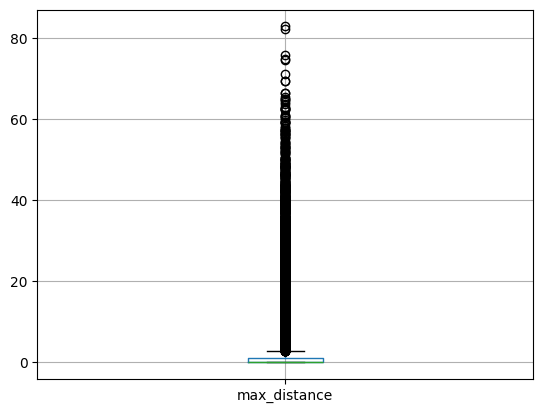

In [31]:
df_users.boxplot(column='max_distance')

In [77]:
np.percentile(df_users['max_distance'], [0, 1, 10, 25, 50, 75, 90, 99, 100])

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.10126392, 19.31257479, 48.19635385, 82.83357618])

25% of the user base started their cycling activities in locations that originally were distant from each other by more that 1.1 km.

# Cluster users

I will proceed will grouping users for the purposes of the joint cycling activity.

I will rely just on the coordinates of the (main) starting points. 

In a more sophisticated approach, other user features could be used for a better user matching. Here, with the data we have, `ride_count`, `cluster_count`, and `max_distance` could be used.

In [32]:
df_users.sample(3)

,ride_count,coordinates,cluster_count,main_cluster_size,main_cluster_centroid_lat,main_cluster_centroid_lon,max_distance
user_id,,,,,,,
7932cf39,2,"[(52.35456790674554, 13.400944857368374), (52....",1,2,52.374446,13.410679,4.618185
e84b2aeb,1,"[(52.49335449469829, 13.449672286046898)]",1,1,52.493354,13.449672,0.000000
67aea470,3,"[(52.5205242352757, 13.507418668723446), (52.4...",2,2,52.447959,13.577081,10.822092


### Clustering #1 - DBSCAN with the Haversine distance

In [87]:
coordinates = df_users[['main_cluster_centroid_lat', 'main_cluster_centroid_lon']].values

# Optional scaling
# coordinates_scaled = StandardScaler().fit_transform(coordinates)

# eps - the maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples - the number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=0.00005, min_samples=10, metric='haversine')

# Fit the model
clusters = dbscan.fit_predict(np.radians(coordinates))  # Convert to radians for haversine distance

df_users['group'] = clusters


df_users.head()

,ride_count,coordinates,cluster_count,main_cluster_size,main_cluster_centroid_lat,main_cluster_centroid_lon,max_distance,group
user_id,,,,,,,,
0000571b,10,"[(52.46788880950156, 13.562554777653745), (52....",6,3,52.440442,13.824672,59.212689,-1
28a01694,10,"[(52.46926072559527, 13.450365223432758), (52....",2,9,52.461657,13.455738,11.830924,-1
40db6af2,10,"[(52.294357738283814, 13.611180227715217), (52...",3,8,52.531345,13.404568,32.355636,0
17f8637e,10,"[(52.68335440767731, 13.28112912130542), (52.6...",1,10,52.675232,13.288516,5.617704,-1
86c04176,10,"[(52.508893784057015, 13.46195941303915), (52....",4,7,52.509182,13.461322,31.778453,0


In [89]:
df_users['group'].value_counts().head()

group
-1     7165
 0     1490
 3       67
 25      49
 10      47
Name: count, dtype: int64

This attempt of the user clustering is not successful. Over 7100 users are not assignes to any cluster (`group=1`), and then 1490 are in the same cluster. 

One could try with different values of the key parameters like `eps` for better results. Instead, I will give another approach a try.

### Clustering #2 - Hierarchical clustering

In [151]:
# Hierarchical clustering of users

coordinates = df_users[['main_cluster_centroid_lat', 'main_cluster_centroid_lon']].values

# Optional scaling
coordinates_scaled = StandardScaler().fit_transform(coordinates)

Z = linkage(coordinates_scaled, method='ward')
# df_users_sub = df_users.sample(1000)

# distance_matrix = pdist(df_users_sub[['main_cluster_centroid_lat', 'main_cluster_centroid_lon']], lambda u, v: calculate_distance_geodesic(u[0], u[1], v[0], v[1]))
# Z = linkage(distance_matrix, method='single')
# print('Linkage...')
# Z = linkage(distance_matrix, method='single', optimal_ordering=True)

# print('Clusters...')
max_distance = 5
clusters = fcluster(Z, max_distance, criterion='distance') # warning if ward: ward's method assumes euclidean distance

df_users['group'] = clusters

Clusters...


In [161]:
groups = df_users.groupby('group')[['main_cluster_centroid_lat', 'main_cluster_centroid_lon']].mean()
groups = groups.rename(columns={'main_cluster_centroid_lat': 'start_point_latitude', 'main_cluster_centroid_lon': 'start_point_longitude'})
groups['group_size'] = df_users.groupby('group').size()

df_users = pd.merge(df_users, groups, left_on='group', right_index=True, how='left')
groups

,start_point_latitude,start_point_longitude,group_size
group,,,
1,52.468081,12.890171,45
2,52.472998,12.679305,33
3,52.638314,12.844509,33
4,52.565613,13.052707,165
5,52.326196,12.728139,21
6,52.271005,12.958440,107
7,52.383306,12.925998,105
8,52.357542,13.005186,208
9,52.364063,13.104860,114


In [162]:
df_users.sample(3)

,ride_count,coordinates,cluster_count,main_cluster_size,main_cluster_centroid_lat,main_cluster_centroid_lon,max_distance,group,start_point_latitude,start_point_longitude,group_size
user_id,,,,,,,,,,,
20650fb5,2,"[(52.33151051930089, 13.420955130770391), (52....",1,2,52.331507,13.420964,0.001475,31,52.326942,13.417005,86
4c5155ee,1,"[(52.44727433260338, 13.759504827817771)]",1,1,52.447274,13.759505,0.000000,18,52.436698,13.750965,213
16a02d51,1,"[(52.54490712061066, 13.244469390312837)]",1,1,52.544907,13.244469,0.000000,41,52.537407,13.201019,264


I would like to understand how much different results the geodesic, Haversine, and Euclidean formulas for distance give.

In [171]:
df_users['distance_to_group_geodesic'] = df_users.apply(lambda row: calculate_distance_geodesic(row['main_cluster_centroid_lat'], row['main_cluster_centroid_lon'], row['start_point_latitude'], row['start_point_longitude']), axis=1)
df_users['distance_to_group_haversine'] = df_users.apply(lambda row: calculate_distance_haversine(row['main_cluster_centroid_lat'], row['main_cluster_centroid_lon'], row['start_point_latitude'], row['start_point_longitude']), axis=1)
df_users['distance_to_group_euclidean'] = df_users.apply(lambda row: math.sqrt(((row['main_cluster_centroid_lat'] - row['start_point_latitude'])*111)**2 + ((row['main_cluster_centroid_lon'] - row['start_point_longitude'])*67)**2), axis=1)

In [172]:
df_users.groupby('group')[['distance_to_group_geodesic', 'distance_to_group_haversine', 'distance_to_group_euclidean']].mean()

,distance_to_group_geodesic,distance_to_group_haversine,distance_to_group_euclidean
group,,,
1,4.610678,4.598787,4.559805
2,6.493657,6.484658,6.457715
3,6.381442,6.369052,6.342216
4,4.306055,4.295838,4.268760
5,3.701900,3.695014,3.667516
6,5.379898,5.367185,5.309556
7,2.180640,2.176753,2.162682
8,3.025620,3.019508,2.995867
9,2.156398,2.152334,2.137042


Now, let's visualize the clusters.

/var/folders/_9/csx7y18d1h72jnzdh86493jr0000gq/T/ipykernel_67281/3350266541.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)  # 'tab10' is a colormap with 10 distinct colors


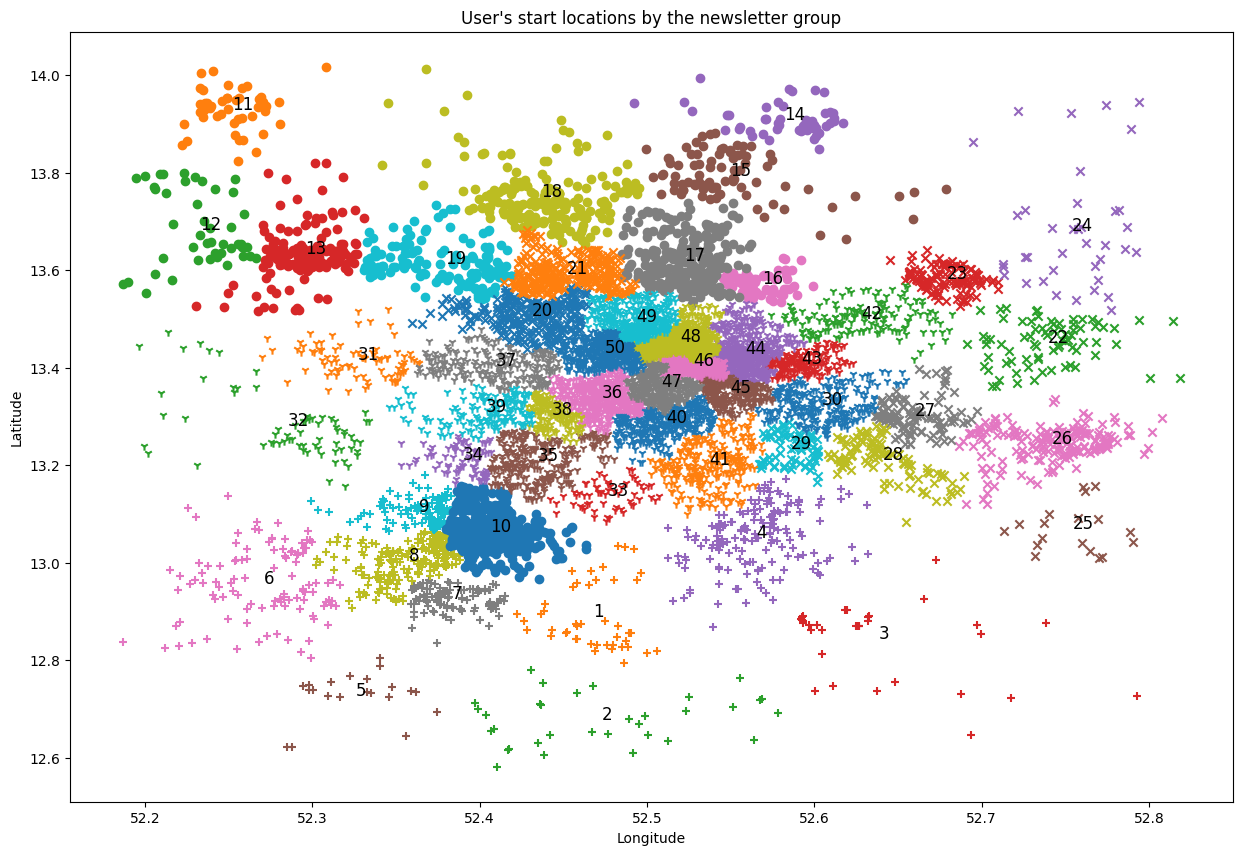

In [194]:
# Visualize clusters

fig, ax = plt.subplots(figsize=(15, 10))

# Function to determine marker based on group ID
def get_marker(group_id):
    if group_id < 0:
        return '^'  # Circle
    elif 0 <= group_id <= 9:
        return '+'  # Plus
    elif 10 <= group_id <= 19:
        return 'o'  # Triangle
    elif 20 <= group_id <= 29:
        return 'x'  
    else:
        return '1'

# Create a color map with 10 unique colors for digits 0-9
cmap = plt.cm.get_cmap('tab10', 10)  # 'tab10' is a colormap with 10 distinct colors

# Group DataFrame by 'group' and plot each group
for group_id, group_df in df_users.groupby('group'):
    marker = get_marker(group_id)
    color = cmap(group_id % 10)  # Use the last digit of the group ID to select a color
    
    ax.scatter(x=group_df['main_cluster_centroid_lat'].values, 
               y=group_df['main_cluster_centroid_lon'].values, 
               color=color, 
               marker=marker, 
               label=f'Group {group_id}')
    
    # Calculate the centroid of the cluster
    centroid_lat = group_df['main_cluster_centroid_lat'].mean()
    centroid_lon = group_df['main_cluster_centroid_lon'].mean()
    
    # Annotate the plot with the cluster ID at the centroid location
    ax.text(centroid_lat, centroid_lon, str(group_id), color='black', fontsize=12)

ax.set_title("User's start locations by the newsletter group")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# plt.legend()
plt.show()

Finally, let us understand how far users would have to travel to the starting point.

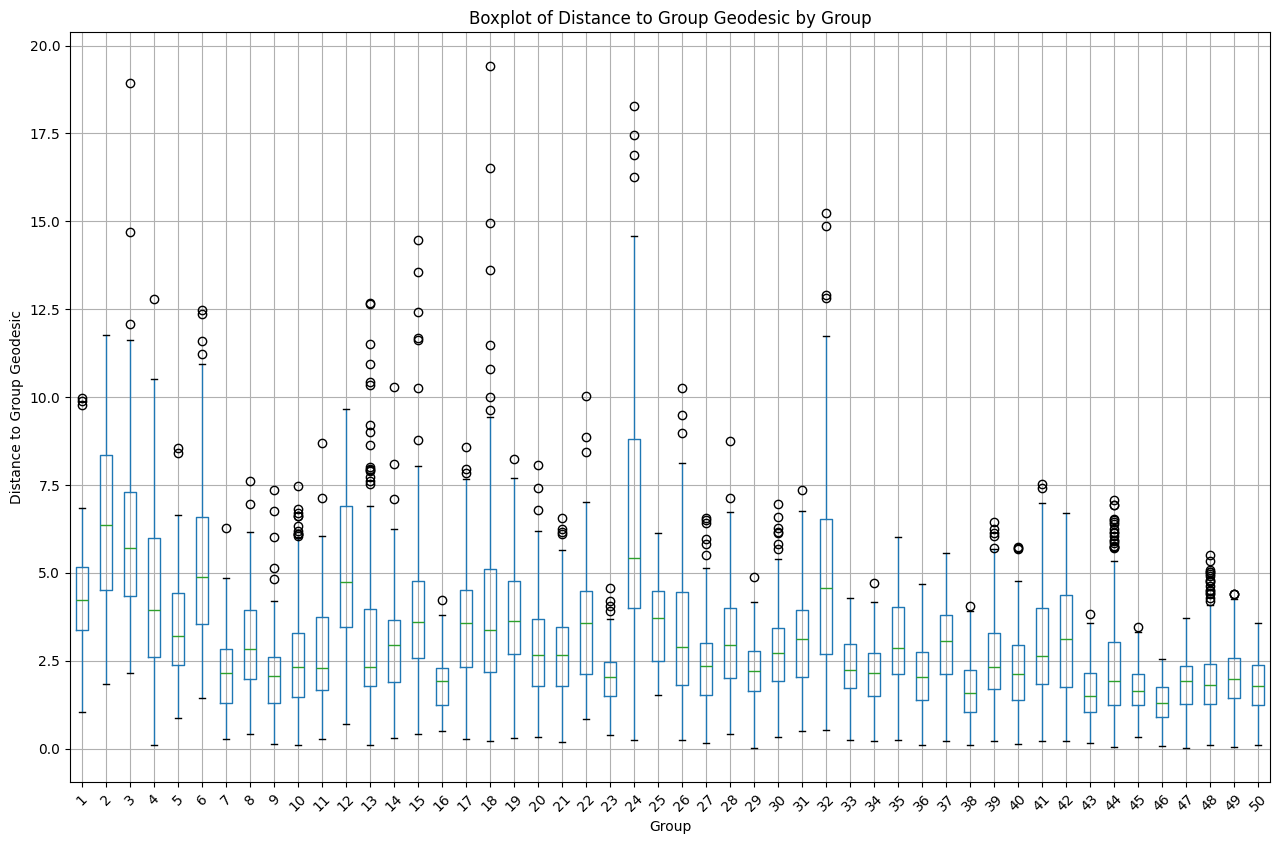

In [197]:
fig, ax = plt.subplots(figsize=(15, 10))
df_users.boxplot(column='distance_to_group_geodesic', by='group', ax=ax, rot=45)

plt.title('Boxplot of Distance to Group Geodesic by Group')
plt.suptitle('') 
plt.xlabel('Group')
plt.ylabel('Distance to Group Geodesic')
plt.show()